In [1]:
import torch
import os
import numpy as np
import util
import data_util
import matplotlib.pyplot as plt
from glob import glob
from scipy.io import loadmat


from deep_voxels import DeepVoxels
from projection import ProjectionHelper

In [2]:
device = torch.device('cuda')
model_path = os.path.join('/home/max/cache/logs/', 'model-epoch_36_iter_24000.pth')
data_path = os.path.join('/home/max/pretest/')
#test_rgb = os.path.join('/home/max/depth_infer_dataset/rgb', 'phone_543_0.png')
#test_pose = os.path.join('/home/max/depth_infer_dataset/pose', 'phone_543_0.mat')
test_rgb = os.path.join('/home/max/pretest/rgb', 'render_7.png')
test_pose = os.path.join('/home/max/pretest/pose', 'camera_7.mat')

In [3]:
img_dim = 256
grid_dim = 32
proj_image_dims = [64, 64]

_, grid_barycenter, scale, near_plane, _ = \
    util.parse_intrinsics(os.path.join(data_path, 'intrinsics.txt'), trgt_sidelength=proj_image_dims[0])

if near_plane == 0.0:
    near_plane = np.sqrt(3)/2

In [4]:
lift_intrinsic = util.parse_intrinsics(os.path.join(data_path, 'intrinsics.txt'),
                                       trgt_sidelength=proj_image_dims[0])[0]
proj_intrinsic = lift_intrinsic

# Set up scale and world coordinates of voxel grid
voxel_size = (1. / grid_dim) * 1.1 * scale
grid_origin = torch.tensor(np.eye(4)).float().to(device).squeeze()
grid_origin[:3,3] = grid_barycenter

# Minimum and maximum depth used for rejecting voxels outside of the cmaera frustrum
depth_min = 0.
depth_max = grid_dim * voxel_size + near_plane
grid_dims = 3 * [grid_dim]

# Resolution of canonical viewing volume in the depth dimension, in number of voxels.
frustrum_depth = int(np.ceil(1.5 * grid_dim))

In [5]:
model = DeepVoxels(lifting_img_dims=proj_image_dims,
                   frustrum_img_dims=proj_image_dims,
                   grid_dims=grid_dims,
                   use_occlusion_net=True,
                   num_grid_feats=64,
                   nf0=64,
                   img_sidelength=img_dim)
model.to(device)


# Projection module
projection = ProjectionHelper(projection_intrinsic=proj_intrinsic,
                              lifting_intrinsic=lift_intrinsic,
                              depth_min=depth_min,
                              depth_max=depth_max,
                              projection_image_dims=proj_image_dims,
                              lifting_image_dims=proj_image_dims,
                              grid_dims=grid_dims,
                              voxel_size=voxel_size,
                              device=device,
                              frustrum_depth=frustrum_depth,
                              near_plane=near_plane)

OcclusionNet(
  (occlusion_prep): Sequential(
    (0): Conv3dSame(
      (net): Sequential(
        (0): ReplicationPad3d((1, 1, 1, 1, 1, 1))
        (1): Conv3d(65, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
      )
    )
    (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (occlusion_net): Unet3d(
    (in_layer): Sequential(
      (0): Conv3dSame(
        (net): Sequential(
          (0): ReplicationPad3d((1, 1, 1, 1, 1, 1))
          (1): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
        )
      )
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (unet_block): UnetSkipConnectionBlock3d(
      (model): Sequential(
        (0): DownBlock3D(
          (net): Sequential(
            (0): ReplicationPad3d((1, 1, 1, 1, 1, 1))
            (1): Conv3d(4, 8, kernel_size=(4, 4, 4), stride=(2, 2,

In [6]:
util.custom_load(model, model_path)
model.eval()

DeepVoxels(
  (feature_extractor): Sequential(
    (0): DownsamplingNet(
      (downs): Sequential(
        (0): DownBlock(
          (net): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
            (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): LeakyReLU(negative_slope=0.2, inplace)
            (4): ReflectionPad2d((1, 1, 1, 1))
            (5): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
            (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (7): LeakyReLU(negative_slope=0.2, inplace)
          )
        )
        (1): DownBlock(
          (net): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
            (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [7]:
pretest_rgb_list = sorted(glob(os.path.join(data_path,'rgb','*.png')))
pretest_pose_list = sorted(glob(os.path.join(data_path,'pose','*.mat')))

In [8]:
inpt_rgbs = list()
backproj_mapping = list()
for j in range(8):
    each_img = data_util.load_img(pretest_rgb_list[j], square_crop=True, downsampling_order=1, target_size=[img_dim, img_dim])
    each_img = each_img[:, :, :3].astype(np.float32) / 255. - 0.5
    each_img = each_img.transpose(2,0,1)
    each_img = torch.from_numpy(each_img)

    each_pose = loadmat(pretest_pose_list[j])['extrinsic']
    each_pose = np.linalg.inv(each_pose).astype(np.float32)
    each_pose = torch.from_numpy(each_pose)

    inpt_rgbs.append(each_img.unsqueeze(0).to(device))
    backproj_mapping.append(projection.comp_lifting_idcs(camera_to_world=each_pose.squeeze().to(device),grid2world=grid_origin))


with torch.no_grad():
    model.representation = torch.zeros((1, model.n_grid_feats, model.grid_dims[0], model.grid_dims[1], model.grid_dims[2])).cuda()

    lift_volume_idcs, lift_img_coords = list(zip(*backproj_mapping))

    model(inpt_rgbs, 'pretest', None, None, lift_volume_idcs, lift_img_coords, None)

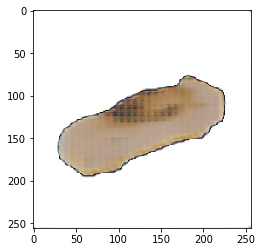

In [9]:
with torch.no_grad():
    trgt_pose = loadmat(pretest_pose_list[0])['extrinsic']
    trgt_pose = np.linalg.inv(trgt_pose).astype(np.float32)
    trgt_pose = torch.from_numpy(trgt_pose)
    trgt_pose = trgt_pose.squeeze().to(device)

    # compute projection mapping
    proj_mapping = projection.compute_proj_idcs(trgt_pose.squeeze(), grid_origin)

    proj_ind_3d, proj_ind_2d = proj_mapping

    # Run through model
    out, _ = model(None, 'test', [proj_ind_3d], [proj_ind_2d], None, None, None)

    out = out[0].squeeze().cpu().detach().numpy()
    out = out.transpose(1, 2, 0)
    out = (out - np.amin(out)) / (np.amax(out) - np.amin(out))
    out = out.squeeze()

plt.imshow(out)

In [10]:
inpt_rgbs = list()
backproj_mapping = list()

each_img = data_util.load_img(test_rgb, square_crop=True, downsampling_order=1, target_size=[img_dim, img_dim])
each_img = each_img[:, :, :3].astype(np.float32) / 255. - 0.5
each_img = each_img.transpose(2,0,1)
each_img = torch.from_numpy(each_img)

each_pose = loadmat(test_pose)['extrinsic']
each_pose = np.linalg.inv(each_pose).astype(np.float32)
each_pose = torch.from_numpy(each_pose)

inpt_rgbs.append(each_img.unsqueeze(0).to(device))
backproj_mapping.append(projection.comp_lifting_idcs(camera_to_world=each_pose.squeeze().to(device),grid2world=grid_origin))


with torch.no_grad():
    model.representation = torch.zeros((1, model.n_grid_feats, model.grid_dims[0], model.grid_dims[1], model.grid_dims[2])).cuda()

    lift_volume_idcs, lift_img_coords = list(zip(*backproj_mapping))

    update = model(inpt_rgbs, 'pretest', None, None, lift_volume_idcs, lift_img_coords, None, return_update=True)

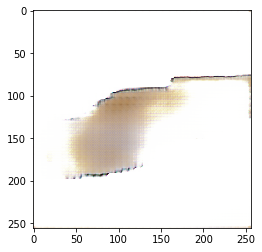

In [11]:
with torch.no_grad():
    trgt_pose = loadmat(pretest_pose_list[0])['extrinsic']
    trgt_pose = np.linalg.inv(trgt_pose).astype(np.float32)
    trgt_pose = torch.from_numpy(trgt_pose)
    trgt_pose = trgt_pose.squeeze().to(device)

    # compute projection mapping
    proj_mapping = projection.compute_proj_idcs(trgt_pose.squeeze(), grid_origin)

    proj_ind_3d, proj_ind_2d = proj_mapping

    # Run through model
    out, _ = model(None, 'test', [proj_ind_3d], [proj_ind_2d], None, None, None)

    out = out[0].squeeze().cpu().detach().numpy()
    out = out.transpose(1, 2, 0)
    out = (out - np.amin(out)) / (np.amax(out) - np.amin(out))
    out = out.squeeze()

plt.imshow(out)

In [12]:
update

tensor([[[[[1.0000, 0.9884, 0.3486,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 0.9912,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [0.3830, 0.3842, 0.3838,  ..., 0.3711, 0.3706, 0.3691],
           [0.3811, 0.3824, 0.3820,  ..., 0.3693, 0.3688, 0.3673],
           [0.3791, 0.3803, 0.3799,  ..., 0.3672, 0.3667, 0.3652]],

          [[0.9939, 0.5332, 0.2250,  ..., 0.9146, 0.9988, 1.0000],
           [1.0000, 0.9955, 0.5870,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 0.9989,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [0.3882, 0.3895, 0.3890,  ..., 0.3762, 0.3757, 0.3742],
           [0.3864, 0.3876, 0.3872,  ..., 0.3744, 0.3739, 0.3724],
           [0.3843, 0.3855, 0.3851,  ..., 0.3723, 0.3719, 0.3704]],

          [[0.3805, 0.2443, 0.6349,  ..., 0.0187, 0.2567, 0.9385],
           [0.9332, 0.4322, 0.4212,  ..., 0.1456, 0.9499, 0.9999],
           [1.0000, 0.9867